# PHYS 210 Mini-Project 04

### Maxwell Boltzmann Distribution

Due Wed, Nov 30, 2022 - 9am


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from itertools import combinations
from IPython.display import HTML

"""
For this project, the given template was followed.
Inital parameters for the simulation are set, then an animation of the gas'
progression is created and saved.

Then, two histograms are created of the speed and kinetic energy distributions of
the gas, with fitted curves showing the temperature of the gas.
"""

# Initial Parameters
npoint = 400
nframe = 500
xmin, xmax, ymin, ymax = 0, 1, 0, 1

# Particle parameters
Dt = 0.00002  # s
prad = 0.0015  # m
pm = 2.672 * 10**(-26)  # kg

x = np.random.random(npoint)
y = np.random.random(npoint)
vx = -500. * np.ones(npoint)
vy = np.zeros(npoint)
vx[x <= 0.5] = -vx[x <= 0.5]

temparr = np.arange(npoint)
combs = np.asarray(list(combinations(temparr, 2)))

carr = np.full(shape=(npoint, 3), fill_value=(0, 0, 0))
carr[x <= 0.5] = (0, 0, 1)
carr[x > 0.5] = (1, 0, 0)


def get_indices(comb_i):
    """
    Gets the respective index of the values used in combinations

    comb_i: index of the pair of values that we want in the combination

    returns index of the first values and the index of the second value
    in the combination term xx
    """

    a = combs[comb_i][:, 0]
    b = combs[comb_i][:, 1]
    return a, b


def update_point(num):
    """
    Function to update the points, updates two time steps then appends data to im
    """
    global x, y, vx, vy
    # 2 steps per frame
    for i in range(2):
        # Time step
        dx = Dt * vx
        dy = Dt * vy
        x = x + dx
        y = y + dy
        indx = np.where((x < xmin) | (x > xmax))
        indy = np.where((y < ymin) | (y > ymax))
        vx[indx] = -vx[indx]
        vy[indy] = -vy[indy]

        xx = np.asarray(list(combinations(x, 2)))
        yy = np.asarray(list(combinations(y, 2)))

        # Distances between particles:
        dd = (xx[:, 0] - xx[:, 1])**2 + (yy[:, 0] - yy[:, 1])**2

        col = np.where(np.sqrt(dd) <= 2 * prad)

        p1, p2 = list(get_indices(col))

        # Need to only use old values when calculating new
        ovx = np.copy(vx)
        ovy = np.copy(vy)
        ox = np.copy(x)
        oy = np.copy(y)

        # Calculating new values
        vx[p1] = (ovx[p1] - ((ovx[p1] - ovx[p2]) * (ox[p1] - ox[p2]) +
                             (ovy[p1] - ovy[p2]) * (oy[p1] - oy[p2])) *
                  (ox[p1] - ox[p2]) / dd[col])
        vx[p2] = (ovx[p2] - ((ovx[p2] - ovx[p1]) * (ox[p2] - ox[p1]) +
                             (ovy[p2] - ovy[p1]) * (oy[p2] - oy[p1])) *
                  (ox[p2] - ox[p1]) / dd[col])
        vy[p1] = (ovy[p1] - ((ovx[p1] - ovx[p2]) * (ox[p1] - ox[p2]) +
                             (ovy[p1] - ovy[p2]) * (oy[p1] - oy[p2])) *
                  (oy[p1] - oy[p2]) / dd[col])
        vy[p2] = (ovy[p2] - ((ovx[p2] - ovx[p1]) * (ox[p2] - ox[p1]) +
                             (ovy[p2] - ovy[p1]) * (oy[p2] - oy[p1])) *
                  (oy[p2] - oy[p1]) / dd[col])

    data = np.stack((x, y), axis=-1)
    im.set_offsets(data)


fig, ax = plt.subplots()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# Creating x, vx, y and vy arrays for each point
x = np.random.random(npoint)
y = np.random.random(npoint)
vx = -500. * np.ones(npoint)
vy = np.zeros(npoint)
vx[np.where(x <= 0.5)] = -vx[np.where(x <= 0.5)]
vy[np.where(y <= 0.5)] = -vy[np.where(y <= 0.5)]
im = ax.scatter(x, y)
im.set_sizes([20])

anim = animation.FuncAnimation(fig,
                               update_point,
                               nframe,
                               interval=30,
                               repeat=False)
anim.save('collide.webm', extra_args=['-vcodec', 'libvpx'])
plt.close()
HTML('<video controls> <source src="collide.webm" ' +
     'type="video/webm"></video>')


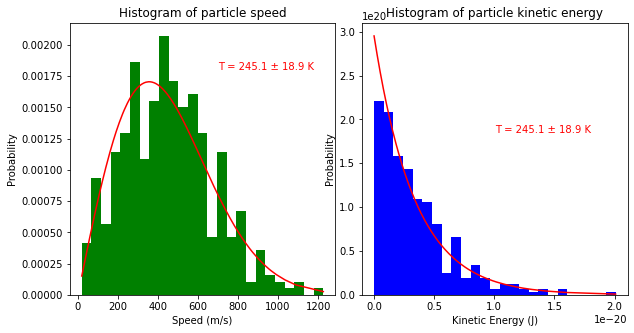

In [2]:
# Plotting cell
import matplotlib.pyplot as plt
import scipy.optimize as sci

vel = np.sqrt(vx ** 2 + vy ** 2)
Ek = 1/2 * pm * vel ** 2
kb = 1.38E-23

velocityhist = np.histogram(vel, 25, density=True)
energyhist = np.histogram(Ek, 25, density=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot 1
ax[0].hist(vel, 25, density=True, color="green")
ax[0].title.set_text("Histogram of particle speed")
ax[0].xaxis.label.set_text("Speed (m/s)")
ax[0].yaxis.label.set_text("Probability")

# Plot 2
ax[1].hist(Ek, 25, density=True, color="blue")
ax[1].title.set_text("Histogram of particle kinetic energy")
ax[1].xaxis.label.set_text("Kinetic Energy (J)")
ax[1].yaxis.label.set_text("Probability")
plt.subplots_adjust(wspace=0.1)


def f(v, T):
    """Fitting function for the speed distribution"""
    return pm * v / T / kb * np.exp(-pm * v ** 2 / (2 * kb * T))


def g(E, T):
    """Fitting function for the kinetic energy distribution"""
    return 1 / (T * kb) * np.exp(-E / (kb * T))


T, tcov = sci.curve_fit(f, velocityhist[1][:-1], velocityhist[0])
terr = np.sqrt(np.diag(tcov))

vel.sort()
Ek.sort()

ax[0].plot(vel, f(vel, T), color='red')
ax[1].plot(Ek, g(Ek, T), color='red')
ax[0].text(700, 0.0018, "T = {:.1f} \u00B1 {:.1f} K".format(
    T[0], terr[0]), color='red')
ax[1].text(np.max(energyhist[1])/2, np.max(energyhist[0])/1.2,
           "T = {:.1f} \u00B1 {:.1f} K".format(T[0], terr[0]), color='red')
plt.show()


# Acknowledgements

In the cell below, please describe the role of **anyone other than yourself** who contributed to the work shown in this notebook.

Its ok to get help from us and classmates! Please get in the habit of acknowledging such contributions.

If you want to refer to a classmate, please use only their cocalc email-id and not their name - or you could just say something like: "a classmate gave me the idea to use xxx feature to solve yyy problem."


_Acknowledgements here:_


# Extension Code and Description

All solution code for the main project question should appear in the two main cells above above. Project extensions go in the cell "cell-extension" immediately below and the descriptions of your extension go in the cell below that.


In [3]:
# OPTIONAL project extension here
# These can call functions in your code above if desired
# YOUR CODE HERE


_In this cell, please describe any new language features or project extension you have implemented:_


# Grading cells

The cells below marked as "grade use only" are created as placeholders so that we can provide a manual grade and comments for each category.

Exceptions are the "2. Style" test, which has an associated autograder test that you can run to check style and the timing cell "cell-optimization0", which you can use to test your code execution time.


In [4]:
# 1. Code execution (grader use only)


In [5]:
# 2. Style: pep8 (see note below regarding use of the Format button to fix many errors)
#
# Tests for pep8 returns warnings or errors. You may need to hit 'Save' after making changes for them to take effect.
nb_name = "project04.ipynb"
cells_to_check = []
stop_at = ['cell-extension']
# check_style2.py uses cells_to_check and nb_name
%run -i check_style2.py


Exception: File `'check_style2.py'` not found.

Also note that you can use the Format button while in a code cell to automagically fix most pep8 errors (other than way too long print statements)

![](project02-format.png)


In [ ]:
# 3. Results (grader use only)


In [ ]:
# 4. Readability (grader use only)


In [ ]:
# 5. Plot (grader use only)


Time for cell: cell-project4-2 time: 40.27


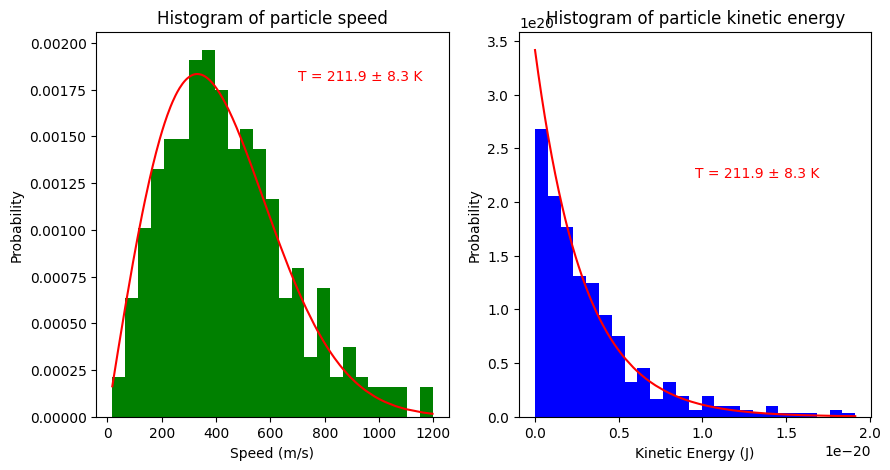

Time for unnamed cell: 0.73
Total time: 41.00


In [ ]:
# Check execution time
nb_name = "project04.ipynb"
cells_to_time = []
stop_at = ['cell-extension']
%run -i time_cells2.py


In [ ]:
# 5. Code optimization/timing (grader use only)


In [ ]:
# B2. New Functionality/Language features (grader use only)
